# Evaluating the Performance of the Classifier

In this notebook we are going to evaluate the performance of the K-NN classifier built for the **Iron Ore** dataset. In order to have a clean notebook, some functions are implemented in the file *utils.py* (e.g., plot_learning_curve). We are not going to discuss the implementation aspects of these functions as it is not the scope, but you can explore and read the content of the functions later on.

Summary:
 - [Data Pre-processing](#data_preprocessing)
 - [Building the K-Nearest Neighbors Classifier](#models)
 - [Quantifying the Quality of Predictions](#pred)
     - [Accuracy](#accuracy)
     - [Confusion Matrix](#confusion)
     - [Precision and Recall](#precision)
     - [F1-score](#f1score)
     - [Receiver Operating Characteristic (ROC) and Area Under the Curve (AUC)](#roc)
     - [K-fold Cross-Validation](#kfold)
     - [Learning Curve](#learning)
  
__All the libraries used in this notebook are <font color='red'>Open Source</font>__.

## Data Pre-processing
<a id=data_preprocessing></a>

In [1]:
# Standard libraries
import numpy as np  # written in C, is faster and robust library for numerical and matrix operations
import pandas as pd # data manipulation library, it is widely used for data analysis and relies on numpy library.
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # plot nicely =)

from sklearn.model_selection import train_test_split #split arrays or matrices into random train and test subsets
from sklearn.preprocessing import StandardScaler #Standardize features by removing the mean and scaling to unit variance

# Auxiliar functions
from utils import *

# the following to lines will tell to the python kernel to always update the kernel for every utils.py
# modification, without the need of restarting the kernel.
%load_ext autoreload
%autoreload 2

# using the 'inline' backend, your matplotlib graphs will be included in your notebook, next to the code
%matplotlib inline

For this first example, we will work on the same dataset as the previous notebook, the **Iron Ore** dataset.

In [2]:
# reading dataset
df = pd.read_csv('../data/iron_ore_study.csv')

# Splits from oscar Fe>60%, SiO2<9, Al2O3<2, P<0.08
split_points = [
    ('FE', 60, [False, True]),
    ('SIO2', 9, [True, False]),
    ('AL2O3', 2, [True, False]),
    ('P', 0.08, [True, False]),  
]

# It's ore if everything is True
df['is_ore'] = np.vstack([
    pd.cut(df[elem], bins=[0, split, 100], labels=is_ore)
    for elem, split, is_ore in split_points
]).sum(axis=0) == 4

y = df.is_ore # set the variable 'y' to store the labels
# removing is_ore from the dataframe 
list = ['is_ore']
df = df.drop(list,axis = 1 )

# split data train 70% and test 30%. You can try other splits here.
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.3, 
                                                    random_state=42)

y_train = y_train.values # converting to numpy array
y_test = y_test.values # converting to numpy array

# normalising the data
scaler = StandardScaler()
scaler.fit(x_train) # not considering the label is_ore
x_train_scaled = scaler.transform(x_train)

x_test_scaled = scaler.transform(x_test)

## Building the K-Nearest Neighbors Classifier
<a id=models></a>

In [3]:
from sklearn.neighbors.classification import KNeighborsClassifier #Classifier implementing the k-nearest neighbors vote.

clf_knn = KNeighborsClassifier(n_neighbors=3)   

clf_knn.fit(x_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

## Quantifying the Quality of Predictions
<a id=pred></a>

The performance assessment of the **classifiers** is extremely important in practice, as this provide insights of how the classifier performs with new data, in which me measure the **generalisation error**.

Summary:
 - [Accuracy](#accuracy)
 - [Confusion Matrix](#confusion)
 - [Precision and Recall](#precision)
 - [F1-score](#f1score)
 - [Receiver Operating Characteristic (ROC) and Area Under the Curve (AUC)](#roc)
 - [K-fold Cross-Validation](#kfold)
 - [Learning Curve](#learning)

### Accuracy
<a id=accuracy></a>

Computes the accuracy of the classifier by  using the following equation:

$$accuracy = \frac{1}{N}\sum_{i=0}^N{1*(\hat{y}==y)}$$
where $y$ is the true label, $\hat{y}$ the predicted label and $N$ is the number of samples.

In [4]:
from sklearn.metrics import accuracy_score

# we are using prediction computed previsously
prediction = clf_knn.predict(x_test_scaled)

accuracy_knn = accuracy_score(y_test, prediction)

print('Accuracy: ', accuracy_knn)

Accuracy:  0.9742857142857143


Nice! We just got 97.4% of **accuracy**. Can we assume that we are done? Let's use other tools to quantify the quality of predictions for our classifier.

### Confusion Matrix
<a id=confusion></a>

The confusion matrix is a tool/technique for summarising the performance of the classifier. We can have better insights about when the classifier is getting right and what are the types of errors it is making. It can be very useful for a further improvement of our models.

<img src="imgs/cm.png" alt="Drawing" style="width: 400px;"/>


In the image above, we have: 
 - **True Positive (TP):** correctly predicted event values.
 - **False Positive (FP):** incorrectly predicted event values.
 - **True Negative (TN):** correctly predicted no-event values.
 - **False Negative (FN):** incorrectly predicted no-event values.


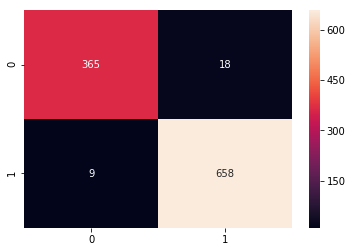

In [5]:
#  confusion_matrix: computes confusion matrix to evaluate the accuracy of a classification
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction)
sns.heatmap(cm, annot=True,fmt="d")

### Precision-Recall
<a id=precision></a>

The confusion matrix give us a lot of information, but sometimes we may need a better metric in order to evaluate the classifier accuracy. Precision and recall scores are two metrics naturally provided by confusion matrix evaluation.


Precision is given by the equation:

$$precision = \frac{TP}{TP + FP}$$
where $TP$ is the number of True Positives and $FP$ is the number of False Positives.


Recall is given by the equation:

$$recall  = \frac{TP}{TP + FN}$$
where $TP$ is the number of True Positives and $FN$ is the number of False Negatives.



In [6]:
# Libraries:
#   precision_score: computes precision score
#   recall_score: computes recall score
from sklearn.metrics import precision_score, recall_score

# we are using prediction computed previsously
precision_knn = precision_score(y_test, prediction)
recall_knn = recall_score(y_test, prediction)

print('Precision: ', precision_knn)
print('Recall: ', recall_knn)


Precision:  0.9733727810650887
Recall:  0.9865067466266867


### F1-score
<a id=f1score></a>

Also known as **F-Measure**, can be interpreted as a weighted average of the precision and recall. The formula for F1-score is:

$$f_1 = 2 * \frac{precision * recall}{precision+recall}$$

In [7]:
from sklearn.metrics import f1_score # computes the f1 score

# we are using prediction computed previsously
f1_score_knn = f1_score(y_test, prediction)
print('F1-score: ', f1_score_knn)

F1-score:  0.9798957557706627


### Receiver Operating Characteristic (ROC) and Area Under the Curve (AUC)
<a id=roc></a>

#### Receiver Operating Characteristic (ROC) 
ROC curve plot the *true positive rate-TPR* (a.k.a. *recall score*) against the *false negative rate-FPR*. FPR is the ratio of negative instances that are incorrectly classifier as positive.


#### Area Under the Curve (AUC)

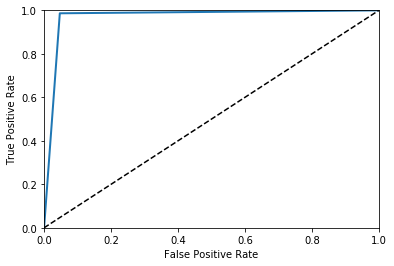

AUC:  0.969754678796372


In [8]:
# Libraries:
#  roc_curve: computes the receiver operating characteristic curve
#  roc_auc_score: computes Area Under the Receiver Operating Characteristic Curve score
from sklearn.metrics import roc_curve, roc_auc_score

# computing and plotting the ROC curve
fpr, tpr, _ = roc_curve(y_test, prediction)

plot_roc_curve(fpr=fpr, tpr=tpr)

# computing the AUC (Area Under the Curve)
auc_knn = roc_auc_score(y_test, prediction)
print('AUC: ', auc_knn)

##### K-fold Cross-Validation
<a id=kfold></a>

In [9]:
# We are using the library StratifiedKFold for this task.
#   The StratifiedKFold performs stratified sampling to produce folds that contain a representative ratio of each 
#   class. At each iteraction the code create a clone of the classifier, train that clone on the training 
#   folds, and makes prediction on the test fold. 
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

cv = StratifiedKFold(n_splits=5, random_state=42)

auc_scores = []
f1_scores = []
for train, test in cv.split(x_train_scaled, y_train):
    clone_clf = clone(clf_knn)
    
    # splitting the training set
    x_train_folds = x_train_scaled[train]
    y_train_folds = y_train[train]
    x_test_folds = x_train_scaled[test]
    y_test_folds = y_train[test]
    
    # building the classifier
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_folds)
    
    # computing the auc score
    auc_scores.append(roc_auc_score(y_test_folds, y_pred))
    
    # computing the f1-score
    f1_scores.append(f1_score(y_test_folds, y_pred))
    

fold = 1
print('Fold\tAUC\tF1-score')
for auc, f1 in zip(auc_scores, f1_scores):
    print('{}\t{:.3f}\t{:.3f}'.format(fold, auc, f1))
    fold += 1

print()
print('Mean AUC: {:.3f}'.format(np.array(auc_scores).mean()))
print('Mean F1-score: {:.3f}'.format(np.array(f1_scores).mean()))

Fold	AUC	F1-score
1	0.965	0.976
2	0.973	0.981
3	0.972	0.981
4	0.955	0.968
5	0.961	0.971

Mean AUC: 0.965
Mean F1-score: 0.976


##### Learning Curve
<a id=learning></a>

<module 'matplotlib.pyplot' from '/Users/00093852/anaconda/envs/week06/lib/python3.6/site-packages/matplotlib/pyplot.py'>

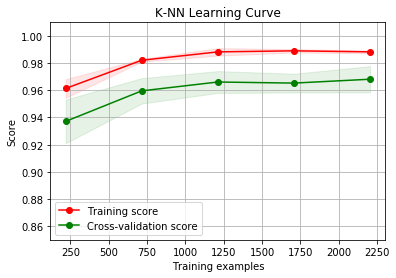

In [10]:
from sklearn.model_selection import StratifiedKFold

# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedKFold(n_splits=10, random_state=42)

plot_learning_curve(clf_knn, title='K-NN Learning Curve', 
                    X=x_train_scaled, 
                    y=y_train, 
                    ylim=(0.85, 1.01), 
                    cv=cv, 
                    n_jobs=5)

#### Your Turn:

1) Build a classifier, you can choise a Random Forest or SVM.

1.1) Build the classifier
    
   For example, for Random Forest you can do:
```python
from sklearn.ensemble import RandomForestClassifier # implements random decision forest.

clf_rf = RandomForestClassifier(n_estimators=20)  # 20 trees in the forest.    
clf_rf.fit(x_train_scaled, y_train)
```

1.2) Evaluate the classifier

In the case of Random Forest, you can do:
```python
pred_rf = clf_rf.predict(x_test_scaled)
```

2) Evaluate the performance of the classifier by using the metrics presented in this notebook:

2.1) Precision and Recall

For example:
```python
precision_rf = precision_score(y_test, pred_rf)
recall_rf = recall_score(y_test, pred_rf)

print('Precision: ', precision_rf)
print('Recall: ', recall_rf)
```

2.2) F1-score

For example:
```python
f1_score_rf = f1_score(y_test, pred_rf)
print('F1-score: ', f1_score_rf)
```

2.3) Plot the ROC curve and compute the AUC score

For example:
```python
# computing and plotting the ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_rf)
plot_roc_curve(fpr=fpr, tpr=tpr)

# computing the AUC (Area Under the Curve)
auc_rf = roc_auc_score(y_test, pred_rf)
print('AUC: ', auc_rf)
```

3) Can we do better? 

To answer this question, compute the learning curve:

For example:
```python
cv = StratifiedKFold(n_splits=10, random_state=42)

plot_learning_curve(clf_rf, title='Random Forest Learning Curve', 
                    X=x_train_scaled, 
                    y=y_train, 
                    ylim=(0.85, 1.01), 
                    cv=cv, 
                    n_jobs=5)
```

**PS: if you are using SVM, choose n_splits small**.


If you whish,  compute the K-fold Stratified Cross validation to get better insights.

4) Compare the evaluation results for the different classifier with the previous K-NN classifier. Could you find some insights about the performance of both classfiers?